In [66]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as im
import helper as hp
import math

#### Problem #1

In [67]:
def read_8bit_img_from_raw_data(filename, height, width):
    # Returns a numpy 2D array of 8bit integers representing image pixels
    # Open specified file
    with open(filename, "rb") as f:
        # Convert bytes read from file into a numpy array
        img = np.frombuffer(f.read(), dtype=np.ubyte)
        # This check is for images with some header, only raw bytes will be read, extra bytes will be sliced out
        if img.size > height * width:
            img = img[img.size-(height*width):]
        return img.reshape((height, width)).astype(np.int32)

def write_8bit_img_to_raw_data(img, filename):
    # Writes the argument numpy 2D array into a file by converting values into single bytes
    # Open Specified file
    with open(filename, "wb") as f:
        # Write bytes into file
        f.write(img.astype(np.ubyte).tobytes())
        print("Image was written to {0}".format(filename))

def normalize(img, ceil=255):
    # Returns a normalized version of the argument numpy 2D array
    # Checks if the image is already normalized
    if img.min() < 0 or img.max() > ceil:
        # Copy the input image
        normalized_img = img.copy()
        # Subtract the minimum of the input image
        normalized_img = normalized_img - img.min()
        # Multiplication of ceil to the ratios of the image pixels with respect to the image maximum
        normalized_img = (ceil * normalized_img / normalized_img.max())
        assert(normalized_img.max() <= ceil)
        return normalized_img.astype(np.int32)
    else:
        return img

def pad(img, padding=2, mode='zeros'):
    padded = np.zeros((img.shape[0]+padding*2, img.shape[1]+padding*2), dtype=np.ubyte)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            padded[i+padding][j+padding] = img[i][j]
    return padded

def mat_mult(mat_1, mat_2):
    assert(mat_1.shape == mat_2.shape)
    return np.multiply(mat_1, mat_2).sum()

def apply_kernel(img, kernel):
    k_h,k_w = kernel.shape
    i_h,i_w = img.shape
    assert(k_h==k_w and k_h%2!=0)
    padding = int(k_h/2)
    padded_img = pad(img, padding)
    result = np.zeros_like(img)
    for i in range(i_h):
        for j in range(i_w):
            row_start, row_end = i, i+k_h
            col_start, col_end = j, j+k_w
            result[i][j] = mat_mult(padded_img[row_start:row_end, col_start:col_end], kernel)
    return result

def sobel(direction='x', move='right'):
    s = np.zeros((3, 3))
    if direction == 'x':
        if move == 'right':
            s[:,0] = [-1, -2, -1]
            s[:,2] = [1, 2, 1]
        else:
            s[:,0] = [1, 2, 1]
            s[:,2] = [-1, -2, -1]
    else:
        if move == 'down':
            s[0,:] = [-1, -2, -1]
            s[2,:] = [1, 2, 1]
        else:
            s[0,:] = [1, 2, 1]
            s[2,:] = [-1, -2, -1]
    return s

def horizontal_gradient(image, direction='forward'):
    padded_image = np.zeros((image.shape[0]+2,image.shape[1]+2))
    padded_image[1:-1, 1:-1] = image
    gradient = np.zeros_like(image).astype(np.float32)
    for i in range(gradient.shape[0]-1):
        for j in range(gradient.shape[1]-1):
            if direction == 'forward':
                gradient[i,j] = padded_image[i+1, j] - padded_image[i, j]
            else:
                gradient[i,j] = padded_image[i, j] - padded_image[i+1, j]
    return hp.normalize(gradient)

def vertical_gradient(image, direction='forward'):
    padded_image = np.zeros((image.shape[0]+2,image.shape[1]+2))
    padded_image[1:-1, 1:-1] = image
    gradient = np.zeros_like(image).astype(np.float32)
    for i in range(gradient.shape[0]-1):
        for j in range(gradient.shape[1]-1):
            if direction == 'forward':
                gradient[i,j] = padded_image[i, j+1] - padded_image[i, j]
            else:
                gradient[i,j] = padded_image[i, j] - padded_image[i, j+1]
    return hp.normalize(gradient)

def gradient_magnitude(h_gradient, v_gradient):
    return hp.normalize(np.sqrt((h_gradient**2).astype(np.float32) + (v_gradient**2).astype(np.float32)))
            
    

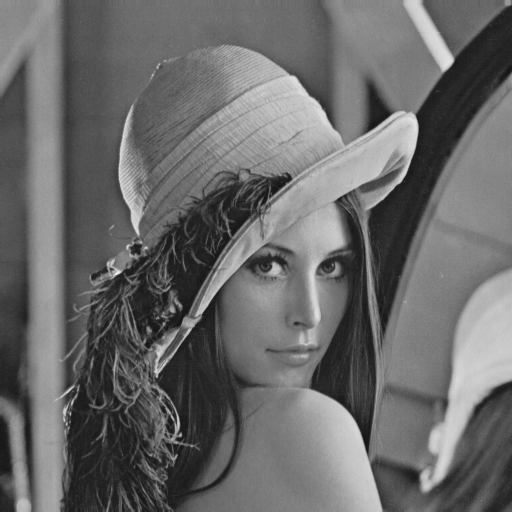

In [68]:
input = hp.read_8bit_img_from_raw_data('data/lena.raw', 512, 512)
im.fromarray(input.astype(np.ubyte))

In [69]:
h_gradient = apply_kernel(input, sobel('x'))
v_gradient = apply_kernel(input, sobel('y'))

Image was written to lena_derivX.raw
Image was written to lena_derivY.raw


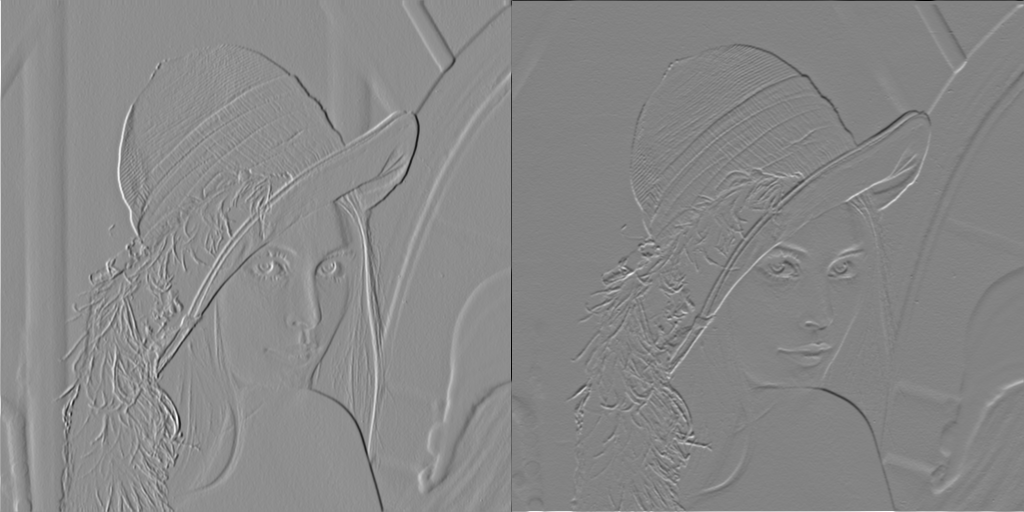

In [70]:
# h_gradient = horizontal_gradient(input, direction='forward')
# v_gradient = vertical_gradient(input, direction='forward')
hp.write_8bit_img_to_raw_data(normalize(h_gradient), 'lena_derivX.raw')
hp.write_8bit_img_to_raw_data(normalize(v_gradient), 'lena_derivY.raw')
output_1 = hp.read_8bit_img_from_raw_data('lena_derivX.raw', 512, 512)
output_2 = hp.read_8bit_img_from_raw_data('lena_derivY.raw', 512, 512)
im.fromarray(np.concatenate((output_1.astype(np.ubyte), output_2.astype(np.ubyte)), axis=1))

Image was written to lena_gradient.raw


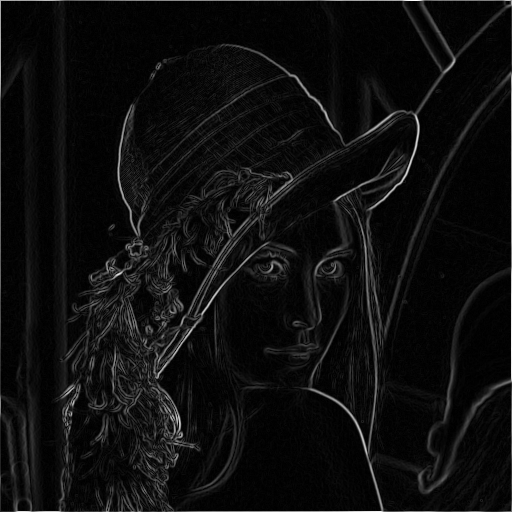

In [71]:
mag = gradient_magnitude(h_gradient, v_gradient)
hp.write_8bit_img_to_raw_data(mag, 'lena_gradient.raw')
output_3 = hp.read_8bit_img_from_raw_data('lena_gradient.raw', 512, 512)
im.fromarray(output_3.astype(np.ubyte))

### Problem 2

In [72]:
def sum_square_difference(image, template):
    result = np.zeros_like(image)
    v_offset, h_offset = math.ceil(template.shape[0]/2), math.ceil(template.shape[1]/2)
    for i in range(v_offset, result.shape[0]-v_offset):
        for j in range(h_offset, result.shape[1]-h_offset):
            # print(f'image: {i}:{i+template.shape[0]}, {j}:{j+template.shape[1]}\tKernel: {template.shape[0]}, {template.shape[1]}')
            part = ((image[i-v_offset:i+v_offset-1, j-h_offset:j+h_offset] - template)**2).sum().sum()
            result[i,j] = part
    return hp.normalize(result)

Image was written to flowers_squared_diff.raw


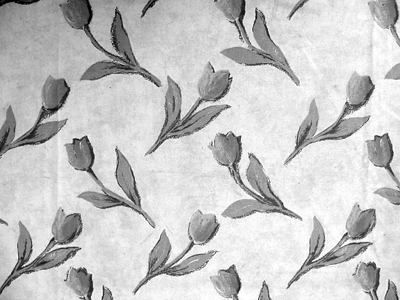

In [73]:
input2 = hp.read_8bit_img_from_raw_data('data/flowers.raw', 300, 400)
input3 = hp.read_8bit_img_from_raw_data('data/flowers-template.raw', 45, 42)
hp.write_8bit_img_to_raw_data(sum_square_difference(input2, input3), 'flowers_squared_diff.raw')
output = hp.read_8bit_img_from_raw_data('flowers_squared_diff.raw', 300, 400)
im.fromarray(input2.astype(np.ubyte))

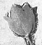

In [74]:
im.fromarray(input3.astype(np.ubyte))

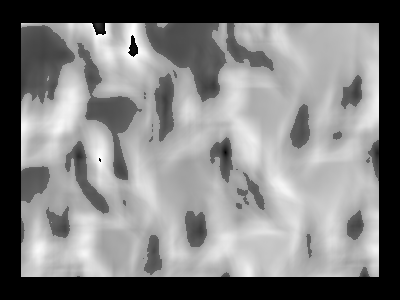

In [75]:
im.fromarray(output.astype(np.ubyte))

#### Problem 3

In [76]:
def correlation_coefficient(image, template):
    result = np.zeros_like(image).astype(np.float32)
    v_offset, h_offset = math.ceil(template.shape[0]/2), math.ceil(template.shape[1]/2)
    for i in range(v_offset, result.shape[0]-v_offset):
        for j in range(h_offset, result.shape[1]-h_offset):
            # print(f'image: {i}:{i+template.shape[0]}, {j}:{j+template.shape[1]}\tKernel: {template.shape[0]}, {template.shape[1]}')
            param1 = image[i-v_offset:i+v_offset-1, j-h_offset:j+h_offset] - image.mean()
            param2 = template - template.mean()
            num = (param1 * param2).sum().sum()
            dom = np.sqrt((param1**2).sum().sum())*np.sqrt((param2**2).sum().sum())
            sol = num/dom
            result[i,j] = sol
    result = hp.normalize(result)
    result[:,:h_offset] = 0
    result[:v_offset,:] = 0
    result[:,-h_offset:] = 0
    result[-v_offset:,:] = 0
    return result

In [77]:
output = correlation_coefficient(input2, input3)
hp.write_8bit_img_to_raw_data(output, 'flowers_correlation_coeff.raw')
output = hp.read_8bit_img_from_raw_data('flowers_correlation_coeff.raw', 300, 400)

Image was written to flowers_correlation_coeff.raw


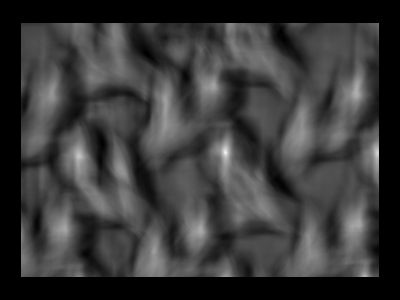

In [78]:
im.fromarray(output.astype(np.ubyte))